In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
from models import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from tqdm import tqdm_notebook as tqdm

# BilinearSampler Test Field

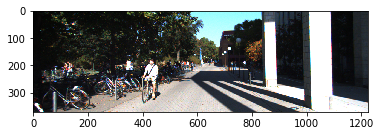

In [5]:
pimg = plt.imread('img/kitti.png')
plt.imshow(pimg); plt.show()

In [42]:
timg = torch.from_numpy(pimg).permute(2,0,1).type(torch.FloatTensor).contiguous()
pimg[:,:,0] - timg[0] 


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 370x1224]

In [43]:
sampler = BilinearProj()

## Test 0: identity sampling

In [44]:
H, W = 370, 1224
offset = Offset3()
offset.cuda()
EPS = 1e-10
camMatrix = [7.070493e+02,0.000000e+00,6.040814e+02, 0,
             0.000000e+00,7.070493e+02,1.805066e+02, 0,
             0.000000e+00,0.000000e+00,1.000000e+00, 0,
             0, 0, 0 ,1]
camMatrix= np.array(camMatrix).reshape(4,4)
inv = np.linalg.inv(camMatrix)

In [45]:
from numpy import sin, cos
a = 3.14/20
Rx = np.array(
    [1, 0, 0,
     0, cos(a), -sin(a),
     0, sin(a), cos(a)]
    ).reshape(3,3)

Ry = np.array(
    [cos(a), 0, sin(a),
     0, 1, 0,
     -sin(a),0, cos(a)]
    ).reshape(3,3)

Rz = np.array(
    [cos(a), -sin(a), 0,
     sin(a), cos(a), 0,
     0, 0, 1]
    ).reshape(3,3)

R = Rx@Ry@Rz

In [46]:
t = np.array([0.3,0.4,0.2]).reshape(3,1)

In [47]:
trans = np.concatenate((R, t), axis=1)
trans = np.concatenate((trans, np.array([0,0,0,1]).reshape(1,4)), axis=0)

In [48]:
trans

array([[ 0.97555, -0.15443,  0.15636,  0.3    ],
       [ 0.17858,  0.97173, -0.15443,  0.4    ],
       [-0.12809,  0.17858,  0.97555,  0.2    ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]])

In [49]:
point = np.array([20, 30, 10, 1]).reshape(4,1)

In [50]:
c_point = trans@inv@point
camMatrix@c_point

array([[ 2120.13216],
       [-1696.18169],
       [   10.59791],
       [    1.     ]])

In [51]:
camMatrix = [7.070493e+02,0.000000e+00,6.040814e+02,0,
             0.000000e+00,7.070493e+02,1.805066e+02,0,
             0.000000e+00,0.000000e+00,1.000000e+00,0,
             0, 0, 0 ,1]
camMatrix= np.array(camMatrix).reshape(4,4)
inv = np.linalg.inv(camMatrix)

In [52]:
camMatrix@trans@inv@point

array([[ 2120.13216],
       [-1696.18169],
       [   10.59791],
       [    1.     ]])

## Test 1: zero pose  

In [53]:
#pose = V(torch.zeros(1,6)) + EPS
trans = V(torch.zeros(1,3)) + EPS
rotation = V(torch.zeros(1,3)) + EPS
# use zero would get NaN

In [54]:
inv_depth = V(torch.ones(1, 1, H, W)) 

In [55]:
camera = V(torch.FloatTensor(np.array([707.0493,707.0493,604.0814,180.5066]))).view(1, -1)

In [56]:
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)

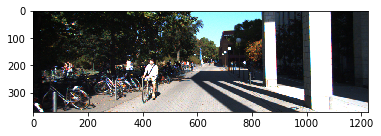

In [57]:
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

### Test 2, rotate in z direction (x,y plane) --> normal image rotation

In [58]:
middle, scale = (370//2, 1224//2), (100, 150)
testsquare = torch.zeros_like(timg)
testsquare[0, middle[0]-scale[0]:middle[0]+scale[0], middle[1]-scale[1]:middle[1]+scale[1]] = 1

In [59]:
trans = V(torch.zeros(1,3)) + EPS
rotation = V(T(np.array((EPS, EPS, 3.14/2))).view(1, -1)) + EPS

In [60]:
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)

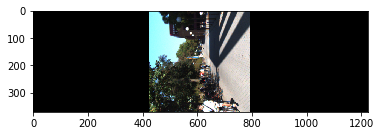

In [61]:
sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

### Test 3, small angle rotate in z direction (x,y plane) --> normal image rotation

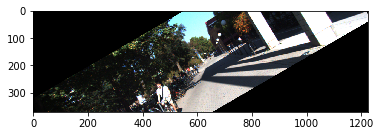

In [62]:
trans = V(torch.zeros(1,3)) + EPS
rotation = V(T(np.array((EPS, EPS, 3.14/6))).view(1, -1)) + EPS
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

### Test 4, small angle rotate in y direction (x,z plane) 

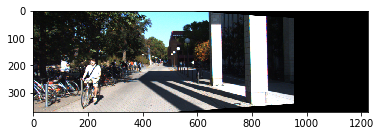

In [63]:
trans = V(torch.zeros(1,3)) + EPS
rotation = V(T(np.array((EPS, 3.14/12, EPS))).view(1, -1)) + EPS
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

### Test 5, small angle rotate in x direction (y,z plane) --> normal image rotation

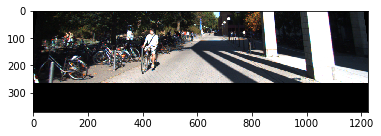

In [64]:
trans = V(torch.zeros(1,3)) + EPS
rotation = V(T(np.array((3.14/20, EPS, EPS))).view(1, -1)) + EPS
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

### Test 5, small displacement in x direction, positive sign means the image would shift in negative direction

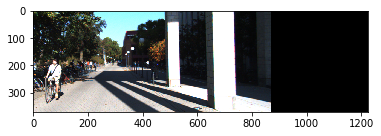

In [69]:
rotation = V(torch.zeros(1,3)) + EPS
trans = V(T(np.array((.5, EPS, EPS))).view(1, -1)) + EPS
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

In [ ]:
### Test 6, reverse warping ability 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


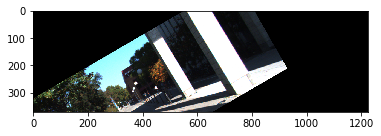

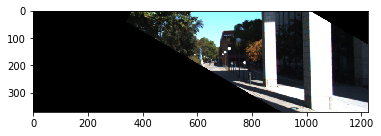

In [71]:
# forward warping in Test 3

trans = V(T(np.array((.5, EPS, EPS))).view(1, -1)) + EPS
rotation = V(T(np.array((EPS, EPS, 3.14/6))).view(1, -1)) + EPS
tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(V(timg.unsqueeze(0)), tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

tx, ty, dmask= offset.forward(trans, rotation, inv_depth, camera, reverse=True)
# sampled, mask = sampler(V(testsquare.unsqueeze(0)), tx, ty)
sampled, mask = sampler(sampled, tx, ty)
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.cpu().numpy() ); plt.show()

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

# testing the loss function

## SSIM loss test

In [ ]:
pimg = plt.imread('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

In [ ]:
timg = torch.from_numpy(pimg).type(torch.FloatTensor).permute(2,0,1)
timg = timg.unsqueeze(0).cuda()

# we can't use randn here since the image value is within (0,1) but not N(0,1)
noise = torch.rand(timg.size()).cuda()
# the mask is to simulate the actual usage where some part is get screened.
mask = torch.zeros_like(timg)
b, c, h, w = timg.shape
mask[:, :, h//5:h//5*4, w//5: w//5*4 ] = 1
timg = timg*mask
noise = noise*mask

mask = V(mask)

timg = V(timg)
noise = Variable(noise, requires_grad=True)


#noise = nn.Parameter(noise)


### The value of SSIM is independent from the factor of the input image

In [ ]:
ssim_loss = SSIM()

print(ssim_loss(timg, noise, mask))
print(ssim_loss(timg*255, noise*255, mask))
print(ssim_loss(timg_norm*122, noise_norm*122, mask))
print(ssim_loss(timg_norm*510, noise_norm*510, mask))


In [ ]:

verbose = 200
count = 0

# Functional: pytorch_ssim.ssim(img1, img2, window_size = 11, size_average = True)
#ssim_value = pytorch_ssim.ssim(timg, noise).data[0]
ssim_loss = SSIM()
ssim_value = ssim_loss(timg, noise, mask).data[0]
print("Initial ssim:", ssim_value)

# Module: pytorch_ssim.SSIM(window_size = 11, size_average = True)
#ssim_loss = pytorch_ssim.SSIM()

optimizer = optim.Adam([noise], lr=0.01)

while ssim_value < 0.98:
    count += 1
    if count % verbose == 0:
        print(ssim_value)
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()
    optimizer.zero_grad()
    ssim_out = -ssim_loss(timg, noise, mask)
    ssim_value = - ssim_out.data[0]
    #print(ssim_value)
    ssim_out.backward()
    optimizer.step()
    
plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
plt.show()  
    

In [ ]:
opt = optim.Adam([noise], lr=0.01)

for i in range(3000):
    opt.zero_grad()
    loss = compute_SSIM( noise, timg).mean()

    #loss = ssim_loss( noise, V(timg), V(mask) )
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

## Test L1 loss

It is obvious that the L1 loss depend on the factor of the image. Therefore, how to balance the SSIM and L1 is an important step to maintain a good gradient during the training.

In [ ]:
from models import *

opt = optim.Adam([noise], lr=0.01)

for i in range(1000):
    opt.zero_grad()
    loss = l1_loss( noise, V(timg), V(mask) )
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

# Test Smooth Loss

In [ ]:
noise = (torch.randn((3,256,256)) + torch.ones((3,256,256))).cuda()
noise = noise.unsqueeze(0)
noise = Variable(noise, requires_grad=True)
#noise = nn.Parameter(noise)

In [ ]:
l = SmoothLoss()

In [ ]:
opt = optim.Adam([noise], lr=0.1)

for i in range(1000):
    opt.zero_grad()
    loss = l(noise)
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

# Test Edge Awareness Loss

In [8]:
import cv2

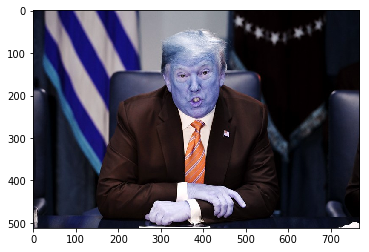

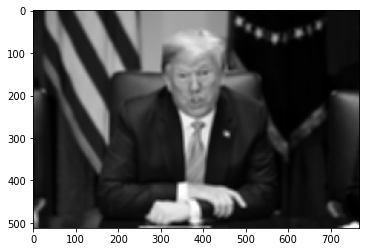

In [9]:
pimg = cv2.imread('img/donald-trump-threatens-ex-obama-officials.jpg')
grayimg = cv2.cvtColor(pimg, cv2.COLOR_RGB2GRAY)
noiseimg = cv2.blur(src=grayimg, ksize=(10,10))
pimg = pimg/255 if pimg.dtype == np.uint8 else pimg

noiseimg = noiseimg/255 if noiseimg.dtype == np.uint8 else noiseimg

plt.imshow(pimg); plt.show()
plt.imshow(noiseimg, cmap="gray"); plt.show()

timg = torch.from_numpy(pimg).type(torch.FloatTensor).permute(2,0,1).cuda()
tnoiseimg = torch.from_numpy(noiseimg).type(torch.FloatTensor).unsqueeze(0).cuda()

In [20]:
noise = (torch.randn( *tnoiseimg.shape)*3).cuda() + tnoiseimg.mean(dim=1, keepdim=True)
noise = noise.unsqueeze(0)

noise = Variable(noise, requires_grad=True)
_noise = noise.data


In [11]:
edgeloss = EdgeAwareLoss().cuda()

In [12]:
timg.unsqueeze(0).shape

torch.Size([1, 3, 512, 768])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


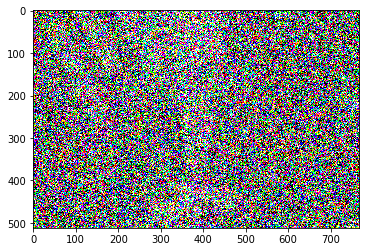

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


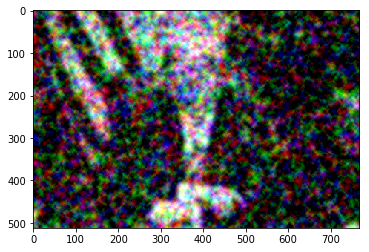

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


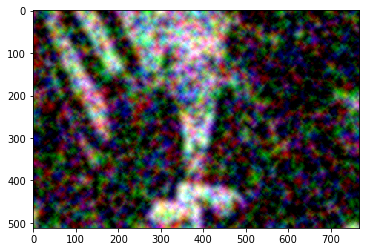

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


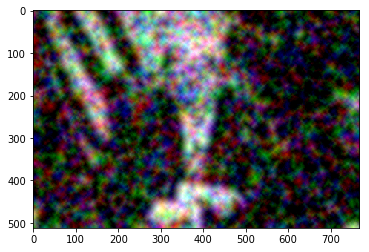

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


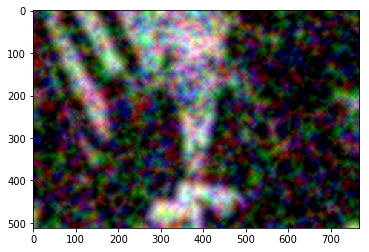

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


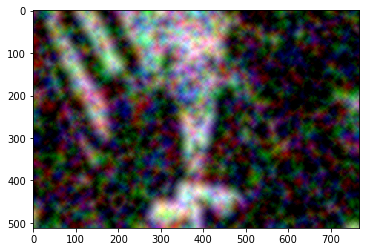

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


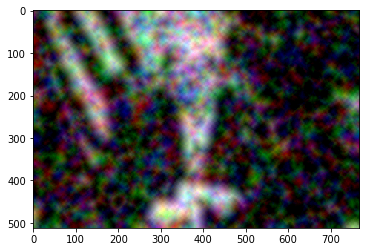

In [15]:
opt = optim.Adagrad([noise], lr=1)

for i in range(1000):
    opt.zero_grad()
    l = edgeloss(Variable(timg.unsqueeze(0)), noise)
    l.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()


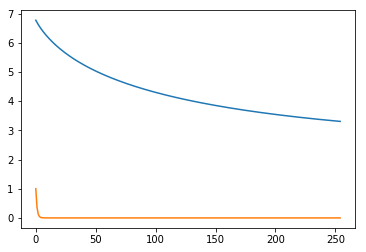

In [23]:
ls = []
for i in range(255):
    l = edgeloss(Variable(timg.unsqueeze(0)*i), V(_noise))
    ls.append(l.data[0])
    
plt.plot(np.arange(255), ls)
plt.plot(np.arange(255), np.exp( -np.arange(255)) )

# Wrap Function Test

In [ ]:
ssim_loss = SSIM()

In [ ]:
train, val= pd.read_csv('./KITTI/training_192_640_pre.csv'), pd.read_csv('./KITTI/validation_192_640_pre.csv')

In [ ]:
index = train.sample(1).index[0]
img1 , img2 = train.loc[index,'t0'], train.loc[index,'t1']

In [ ]:
img1, img2 = plt.imread('./KITTI/'+img1), plt.imread('./KITTI/'+img2)
fig, axs = plt.subplots(2,1)
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()

In [ ]:
img1 = torch.from_numpy(img1 ).permute(2,0,1).unsqueeze(0).contiguous() 
img2 =  torch.from_numpy( img2 ).permute(2,0,1).unsqueeze(0).contiguous() 

In [ ]:
trans = Variable( torch.randn(1,3).cuda() * 0.001, requires_grad=True )
rot = Variable( torch.randn(1,3).cuda() * 0.01, requires_grad=True )

scale = 0
b, c, h, w = img1.size()
depth = Variable( torch.ones(b, c, h//2**scale, w//2**scale).cuda(), requires_grad=True )

#depth = Variable( torch.randn(img1.size()).cuda(), requires_grad=True )

camera = V(torch.FloatTensor([370.454846,366.80941,309.62854,92.687081]).cuda().unsqueeze(0))

In [ ]:
trans.requires_grad

In [ ]:
depth.mean(), depth.std()

In [ ]:
offset = Offset3().cuda()
sampler = BilinearProj().cuda()
smooth  = SmoothLoss()

In [ ]:
losses = []

In [ ]:
opt = optim.Adam([trans, rot], lr=0.001)
opt2 = optim.Adam([depth], lr=.01)
for i in tqdm(range(1000)):
    
    opt.zero_grad()
    opt2.zero_grad()

    if scale>0:
        updepth = F.upsample(input=depth, scale_factor=2**scale, mode='bilinear')
    else:
        updepth = depth    
    
    inv_depth = F.sigmoid(updepth) * 10 + 0.01
    cx12, cy12, d_mask12 = offset.forward(trans, rot, inv_depth = inv_depth, camera = camera)
    x12, in_mask12 = sampler.forward(V(img1), cx12, cy12)

    #m = (d_mask12*in_mask12).unsqueeze(1)     
    m = d_mask12.unsqueeze(1)
    
#     loss = .15*l1_loss( V(img2), x12, m) + .85*ssim_loss( V(img2), x12, m) #+ smooth(inv_depth) * 10
    loss = .85*l1_loss( V(img2), x12, m) + .15*ssim_loss( V(img2), x12, m) #+ smooth(inv_depth) * 10
#     loss = .85*l1_loss( V(img2), x12, m)
    #loss = ssim_loss( V(img2), x12, m )
    #loss += .15*ssim_loss( V(img2), x12, m) 
    loss += smooth(inv_depth) * 50
    losses.append(loss.data[0])
    loss.backward()
    opt.step()
    opt2.step()

In [ ]:
loss

In [ ]:
rot

In [ ]:
trans

In [ ]:
inv_depth.mean(), inv_depth.std(), inv_depth.min(), inv_depth.max()

In [ ]:
def plot_img(recon, index=0, figsize=(12,4)):
    recon = recon[index].permute(1,2,0).numpy()
    plt.figure(figsize=figsize)
    plt.imshow(recon)
    plt.axis('off')    

In [ ]:
def plot_depth(depth, index=0, figsize=(12,4), scale=50, inv=True):
    inv_depth = depth.cpu().data[index].numpy()
    inv_depth = np.clip(inv_depth, a_min=0.01, a_max=None)
    if inv:
        depth = 1/inv_depth[0]
    else:
        depth = inv_depth[0]
        
    m, std, mx = depth.mean(axis=(0, 1)), depth.std(axis=(0, 1)), depth.max(axis=(0, 1))
    plt.figure(figsize=figsize)
    plt.imshow(
        depth*scale,
        cmap = "gray"
        #cmap="viridis",
        #vmin=max(m - 2*std, 0),
        #vmax=min(m+2*std, mx)
    )
    plt.colorbar()
    plt.axis('off')

In [ ]:
def plot_mask(mask, index=0, figsize=(12,4)):
    plt.style.use('grayscale')
    mask = mask[index]
    plt.figure(figsize=figsize)
    plt.imshow(mask.cpu().data.numpy(),cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.axis('off')

In [ ]:
plot_depth(inv_depth, index=0, scale=1,inv=False)

In [ ]:
plot_mask(d_mask12, index=0)

In [ ]:
plot_mask(in_mask12, index=0)

In [ ]:
plot_img(x12.cpu().data)

In [ ]:
plot_img(img2)

In [ ]:
plot_img(img1)

In [ ]:
sns.distplot(inv_depth.cpu().data.view(-1).numpy())

# Percetual Loss

In [ ]:
from scipy import ndimage

In [ ]:
f

In [ ]:
rn = f(False)
layers = children(rn); 
layers = layers[:5]
layers

In [ ]:
pc = nn.Sequential(*layers)

In [ ]:
pc= pc.cuda()
pc.eval()
set_trainable(pc, False)

In [ ]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
pc= nn.Sequential(*children(m_vgg)[:37])

In [ ]:
def pl(x1, x2):
    res1= pc(x1)
    res2 = pc(x2)
    return F.mse_loss(res1, res2)

In [ ]:
pimg = open_image('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

In [ ]:
sz = 288
trn_tfms, val_tfms = tfms_from_model(f, sz)
timg = val_tfms(pimg)
timg.shape
timg_v = V(timg[None])

In [ ]:
noise = np.random.uniform(0,1, size=pimg.shape)
noise = scipy.ndimage.filters.median_filter(noise, [8,8,1])

In [ ]:
noise = val_tfms(noise)/2
noise_v = V(noise[None], requires_grad=True)
noise_v.shape

In [ ]:
pl(timg_v, noise_v)

In [ ]:
verbose = 100
count = 0
#optimizer = optim.LBFGS([noise_v], lr=0.5)
#optimizer = optim.SGD([noise_v], lr = 0.001, momentum=0.8 )
optimizer = optim.Adam([noise_v], lr=0.1)

for i in range(1000):
    count += 1
    if count % verbose == 0:
        plt.imshow(noise_v.cpu().data[0].permute(1,2,0).numpy());
        plt.show()
    optimizer.zero_grad()
    loss = pl(timg_v, noise_v)
    loss_value = loss.data[0]
    #print(loss_value)
    loss.backward()
    optimizer.step()
    
plt.imshow(noise_v.cpu().data[0].permute(1,2,0).numpy());
plt.show()  
    

In [ ]:
?? get_base

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.perceptor = get_base(f, 2)
        
    def forward(self, x1, x2):
        return torch.mse(self.perceptor(x1)-self.perceptor(x2))